In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad

import time
from IPython.core.debugger import set_trace

from numpy import genfromtxt



SyntaxError: invalid syntax (<ipython-input-5-28d4f4469f42>, line 14)

In [2]:
p1 = 0.00183*60
p2 = 66.92400 
p3 = 0.00085*60
p4 = 94.89100
p5 = 0.28130
p6 = 1.96580

In [10]:
def f_MELT(t,x):
    x = np.array(x)
    return(p1 * (p2 - x))

def f_IDLE(t,x):
    x = np.array(x)
    return(p3 * (p4 - x))

def f(t,x,tau_MELT,tau_IDLE):
    for i in range(tau_MELT.size-1):
        if tau_MELT[i] <= t and t < tau_IDLE[i+1]: # Check if MELT
            return(f_MELT(t,x))
        
        elif tau_IDLE[i] <= t and t < tau_MELT[i]: # Check if IDLE
            return(f_IDLE(t,x))

    # If last interval
    return(f_IDLE(t,x))

def f_wrt_x(t,x,tau_MELT,tau_IDLE):
    for i in range(tau_MELT.size-1):
        if tau_MELT[i] <= t and t < tau_IDLE[i+1]: # Check if MELT
            return(-p1)
        
        elif tau_IDLE[i] <= t and t < tau_MELT[i]: # Check if IDLE
            return(-p3)

    # If last interval
    return(-p3)

def c_wrt_x(t,x,q,k):
    return(q*k)


In [24]:
def plot_solution(tau,f,T,t,x0):
    Ncycles = int(tau.size/2)
    tau_IDLE = tau[0:Ncycles]
    tau_MELT = tau[Ncycles:]

    tau_IDLE_all = np.insert(tau_IDLE,0,0)
    tau_MELT_all = np.append(tau_MELT,T)

    sol = solve_ivp(f, [0, T], [x0], args=(tau_MELT_all,tau_IDLE_all),t_eval=t)
    t_sol = sol.t
    x_sol = sol.y[0]

    plt.plot(t_sol,x_sol)

In [27]:
# Extract solution from C++
switches = genfromtxt('optimal_pars.csv', delimiter=',')
n_switches = switches.size
n_cycles = int(n_switches/2)
tau_MELT = switches[np.arange(0,n_switches,2)]
tau_IDLE = switches[np.arange(1,n_switches,2)]
tau_MELT, tau_IDLE

(array([  54.7997,  210.092 ,  436.999 ,  780.205 , 1368.89  ]),
 array([ 154.472,  358.417,  652.315, 1077.91 , 1368.89 ]))

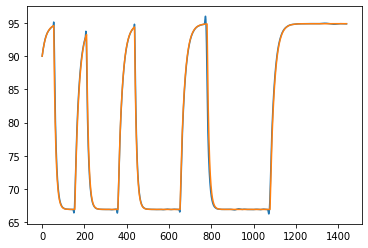

In [31]:
# Extract solution trajectories
traj = genfromtxt('sol_trajectory.csv', delimiter=',')
t = traj[:,0]
obj = traj[:,1]
x = traj[:,2]

plot_solution(np.concatenate( (tau_IDLE, tau_MELT) ),f, t[-1], t, x[0])
plt.plot(t,x)

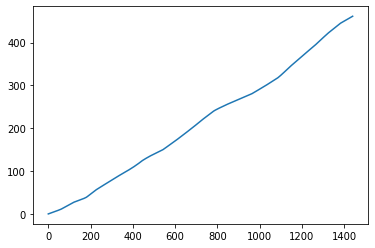

In [32]:
plt.plot(t,obj)

In [187]:
dap = np.zeros((2))
for k in range(2): dap[k] = 0.10 * k
 
dat = np.zeros((4))
for k in range(4): dat[k] = k * 60.;
dat[0] = dat[0] - 60;
dat[3] = dat[3] + 60;
dat/60

array([-1.,  1.,  2.,  4.])

array([0. , 0.1])

3.4007379973153515

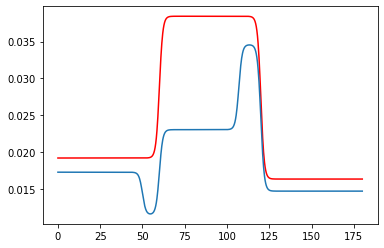

In [190]:
t = np.linspace(0,3*60,1000)
day_ahead_price = 0.;
regime = 0.;

dap = np.array([15.5, 31., 13.2])/1000000 * 1240
on = np.array([50])
off = np.array([107])
for k in range(len(dap)):
        day_ahead_price += dap[k] / ((1. + np.exp(np.minimum(-1 * (t - dat[k]), 15.0 ))) *
                         (1. + np.exp( np.minimum(1. * (t - dat[k + 1]), 15.))))
        
for k in range(int(2/2)):
        regime += 1/ ((1. + np.exp(np.minimum(-1 * (t - on[k]), 15.0 ))) *
                         (1. + np.exp( np.minimum(1. * (t - off[k]), 15.))))
        
plt.plot(t,day_ahead_price, color = 'r')
#plt.plot(t,regime, color = 'g')
price = day_ahead_price * (0.60 + 0.30 * (1-regime))
plt.plot(t,price)

np.sum(price * (t[2] - t[1]))

1382.9821623149865

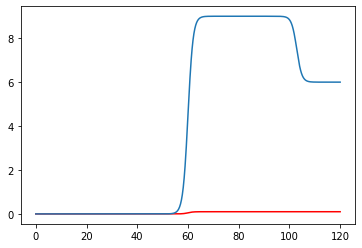

In [102]:
60*24/10 * np.linspace(1,10,10)

array([ 144.,  288.,  432.,  576.,  720.,  864., 1008., 1152., 1296.,
       1440.])

In [132]:
tf = 60*24
n_s = 1
on = np.zeros(n_s)
off = np.zeros(n_s)
on[0] = tf/(2*n_s) + 1.;
for k in range(n_s-1):
    off[k] = on[k]  + tf/(2*n_s) + 1.;
    on[k+1] = off[k] + tf/(2*n_s) + 1.;
off[n_s-1] = on[n_s-1] + tf/(2*n_s) - 2 * n_s * 1.
on, off

(array([721.]), array([1439.]))

In [131]:
on - off

array([-73., -73., -73., -73., -73., -73., -73., -73., -73., -52.])

In [97]:
np.arange(60*24/(5),60*24,60*24/(5))

array([ 288.,  576.,  864., 1152.])

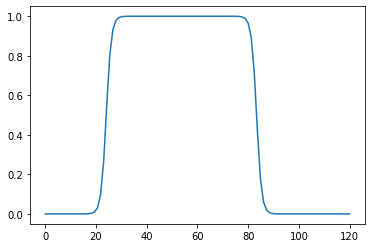

In [139]:
t = np.linspace(0,2*60,100)
on = np.array([24.0263])
off = np.array([83.3087])
model_regime = 0.;
for k in range(1):
    model_regime += 1. / ((1. + np.exp(np.minimum(-1 * (t - on[k]), 15.))) *
                          (1. + np.exp(np.minimum(1 * (t - off[k]), 15.))));
    
plt.plot(t,model_regime)

In [137]:
t

array([   0.        ,    2.88288288,    5.76576577,    8.64864865,
         11.53153153,   14.41441441,   17.2972973 ,   20.18018018,
         23.06306306,   25.94594595,   28.82882883,   31.71171171,
         34.59459459,   37.47747748,   40.36036036,   43.24324324,
         46.12612613,   49.00900901,   51.89189189,   54.77477477,
         57.65765766,   60.54054054,   63.42342342,   66.30630631,
         69.18918919,   72.07207207,   74.95495495,   77.83783784,
         80.72072072,   83.6036036 ,   86.48648649,   89.36936937,
         92.25225225,   95.13513514,   98.01801802,  100.9009009 ,
        103.78378378,  106.66666667,  109.54954955,  112.43243243,
        115.31531532,  118.1981982 ,  121.08108108,  123.96396396,
        126.84684685,  129.72972973,  132.61261261,  135.4954955 ,
        138.37837838,  141.26126126,  144.14414414,  147.02702703,
        149.90990991,  152.79279279,  155.67567568,  158.55855856,
        161.44144144,  164.32432432,  167.20720721,  170.09009

In [33]:
def sigmoid_app(t,start,end,val,slope):
    y = 0
    for i in range(0,val.size):
        v = val[i]/(1. + np.exp(np.minimum(20.,-slope * (t-start[i]))))
        z = val[i]/(1. + np.exp(np.minimum(20.,-slope * (t-end[i]))))
        y += v-z
    return(y)

def step_func(t,start,end,val):
    y = np.zeros(t.size)

    for i in range(start.size):
        y[(start[i] <= t) & (t <= end[i])] = val[i]
    
    return(y)

y_step = step_func(t,start,end,val)
#plt.plot(y_step)
def convert_array(hours,val):
    hours = np.append(hours,hours[-1]+1)
    hours[0] = hours[0]-1
    hours *= 60
    
    val = np.append(val,val[-1])
    
    return hours, val

NameError: name 'start' is not defined

In [ ]:
#nhours = 24
slope = 0.6
hours = np.array(range(0,24+1))
val = np.array([15.5,31,21,35,36,35,28,33,28,41,44,36,32,28,24,25,34,36,41,37,35,39,34,24])
hours, val = convert_array(hours,val)

start = hours[:-1]
end = hours[1:]

y_app = sigmoid_app(t,start,end,val,slope)
y_step = step_func(t,start,end,val)
fig = plt.figure(figsize=(18,7))    
ax = fig.add_subplot(111)
ax.plot(t,y_app,color='b')
ax.plot(t,y_step,color='r')
ax.set_xticks(np.arange(0,val.size,4)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,val.size,4) * 60.])
ax.grid()
hours/60

In [ ]:
# Extract solution trajectories
traj = genfromtxt('sol_trajectory.csv', delimiter=',')
t = traj[:,0]
obj = traj[:,1]
x = traj[:,2]

In [ ]:
slope = 0.6
hours = np.array(range(0,24+1))
val = np.array([15.5,31,21,35,36,35,28,33,28,41,44,36,32,28,24,25,34,36,41,37,35,39,34,24])
hours, val = convert_array(hours,val)
def sigmoid_app(t,dummy,start,end,val,slope):
    y = 0
    for i in range(0,val.size):
        v = val[i]/(1. + np.exp(np.minimum(20.,-slope * (t-start[i]))))
        z = val[i]/(1. + np.exp(np.minimum(20.,-slope * (t-end[i]))))
        y += v-z
    return(y/1000000 * 12400)

In [ ]:
sol = solve_ivp(sigmoid_app, [0, 60*24], [0], args=(start,end,val,slope),t_eval=t)

In [ ]:
plt.plot(sol.t,sol.y[0],'r')
plt.plot(t,obj,'b')
plt.plot(t,x/100 * sigmoid_app(t,0,start,end,val,slope)*300,'g')
sol.y[0][-1]
plt.grid()

In [ ]:
vvector start = {-60.0,   60.0,  120.0,  180.0,  240.0,  300.0,  360.0,  420.0,  480.0, 540.0,  600.0,
                     660.0,  720.0,  780.0,  840.0,  900.0,  960.0, 1020.0, 1080.0, 1140.0, 1200.0, 1260.0,
                     1320.0, 1380.0, 1440.0};
    vvector end = {60.0,  120.0,  180.0,  240.0,  300.0,  360.0,  420.0,  480.0, 540.0,  600.0,
                     660.0,  720.0,  780.0,  840.0,  900.0,  960.0, 1020.0, 1080.0, 1140.0, 1200.0, 1260.0,
                     1320.0, 1380.0, 1440.0, 1500.0};

In [ ]:
t

In [ ]:
sigmoid_app(40.32,start,end,val,slope)

In [ ]:
start

In [ ]:
t = np.linspace(0,24*60,1000)
plt.plot(t,sigmoid_app(t,start,end,val,slope))

In [ ]:
hours = np.append(hours,hours[-1])

In [ ]:
#nhours = 24
slope = 0.6
hours = 60*np.array(range(-1,24+1))

hours = np.array([0,1,2,3,4])
val =  np.array([2,4,1.5,7,10])


hours[0] = hours[0]-1
hours = np.append(hours,hours[-1])
hours = 60*hours
t = np.linspace(0.,hours[-1],1000)


val = np.insert(val, 0, val[0], axis=0)
val = np.append(val,val[-1])
print(val)


t = np.linspace(0,hours[-1],1000)

start = hours[:-1]
end = hours[1:]
#val = np.array([15.5,31,21,35,36,35,28,33,28,41,44,36,32,28,24,25,34,36,41,37,35,39,34,24,24])
y_app = sigmoid_app(t,start,end,val,slope)
y_step = step_func(t,start,end,val)
fig = plt.figure(figsize=(18,7))    
ax = fig.add_subplot(111)
ax.plot(t,y_app,color='b')
ax.plot(t,y_step,color='r')
ax.set_xticks(np.arange(0,val.size,1)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,val.size,1) * 60.])
ax.grid()

In [ ]:
i = 0
plt.plot(t,sigmoid(t,))

In [ ]:
## hours = 60*np.array([-1,1,2,3])
t = np.linspace(0,hours[-1]-60,1000)
val = np.array([5,3,3])
start = hours[:-1]
end = hours[1:]

i = 1
y = 0
z = 0
y += val[i]/(1. + np.exp(-1 * (t-start[i])))
z += val[i]/(1. + np.exp(-1 * (t-end[i])))
#plt.plot(t,y)
#plt.plot(t,z)
plt.plot(t,y-z)

In [ ]:
hours[-1]

In [ ]:
def sigmoid(x, xa, xb, y, k):
    _out = 0.
    print(len(y))
    print(len(xa))
    print(len(xb))
    for j in range(0, len(y)):
        _out += y[j] / ((1. + np.exp(np.minimum(20.,-k * (x-xa[j]))))* (1. + np.exp(np.minimum(20., k * (x-xb[j])))))
    return _out

In [ ]:
y1 = sigmoid(t,start,end,val,0.25)
plt.plot(t,y1)

In [ ]:
y1

In [ ]:
T = 24 * 60
tau = np.concatenate([tau_IDLE,tau_MELT])
t = np.linspace(0,T,1000)

x0 = 90
plot_solution(tau,f,T,t)

## Objective function

In [ ]:
k_IDLE = 9
k_MELT = 250
k = 12.4
x0 = 90

In [ ]:
def q(t):
    t = np.array(t)
    prices = np.zeros(t.size)
    prices = np.sin(t) + 20
    #prices[t < T/2] = 1e-6
    #prices[t >= T/2] = 2e-6
    return(prices)

def integrand(t,sol_obj,q,k):
    return(sol_obj.sol(t) * q(t)*k)

In [ ]:
# Compute c
def c(t,x0,tau,k,k_MELT,k_IDLE):
    
    Ncycles = int(tau.size/2)
    tau_IDLE = tau[0:Ncycles]
    tau_MELT = tau[Ncycles:]
    tau_IDLE_all = np.insert(tau_IDLE,0,0)
    tau_MELT_all = np.append(tau_MELT,T)

    # Compute obj
    sol = solve_ivp(f, [0, T], [x0], t_eval=[t], args=(tau_MELT_all,tau_IDLE_all))

    tau_MELT = tau_MELT_all
    tau_IDLE = tau_IDLE_all

    # Consider removing IDLE checks since redundant
    for i in range(tau_MELT.size-1):
        if tau_MELT[i] <= t and t < tau_IDLE[i+1]: # Check if MELT
            k_status = k_MELT

        elif tau_IDLE[i] <= t and t < tau_MELT[i]: # Check if IDLE
            k_status = k_IDLE

    # If last interval
    k_status = k_IDLE

    # Compute the objective
    return(sol.y[0], q(t) * (k * sol.y[0] + k_status))

def plot_c(t,c,x0,tau,k,k_MELT,k_IDLE):
    x, cost = zip(*[c(t[i],x0,tau,k,k_MELT,k_IDLE) for i in range(t.size)])
    plt.plot(t,cost)
    return(x)

# SHOULD TAKE THE CURRENT SOLUTION AS INPUT. NOT IMPORTANT WHEN X IS NOT PRESENT IN f_wrt_x
def lambda_dot(t,lambda_fun,tau_MELT,tau_IDLE,q,k):
    x = 0 # Notice we use x=0 because x is not used in f_wrt_x
    return(-f_wrt_x(t,x,tau_MELT,tau_IDLE)*lambda_fun - c_wrt_x(t,x,q(t),k))

# Build the integral one subinterval at a time
def obj_fun(tau,T,x0,f,q,k_IDLE,k_MELT,k,lambda_dot):
    Ncycles = int(tau.size/2)
    tau_IDLE = tau[0:Ncycles]
    tau_MELT = tau[Ncycles:]
    
    tau_IDLE_all = np.insert(tau_IDLE,0,0)
    tau_MELT_all = np.append(tau_MELT,T)

    Ncycles = tau_MELT_all.size - 1
    current_x = x0
    
    I = 0
    for cycle in range(Ncycles-1):
        
        #set_trace()

        # IDLE PERIOD
        sol = solve_ivp(f, [tau_IDLE_all[cycle], tau_MELT_all[cycle]], [current_x], dense_output=True, args=(tau_MELT_all,tau_IDLE_all))
        I += quad(integrand, tau_IDLE_all[cycle], tau_MELT_all[cycle], args=(sol,q,k))[0]
        I += k_IDLE * quad(q, tau_IDLE_all[cycle], tau_MELT_all[cycle])[0]

        #t_plot = np.linspace(tau_IDLE_all[i], tau_MELT_all[i],100,1)
        #plt.plot(t_plot,k*q(t_plot)*sol.sol(t_plot)[0])
        # MELT PERIOD
        current_x = sol.sol(tau_MELT_all[cycle])[0]
        #print(current_x)
        sol = solve_ivp(f, [tau_MELT_all[cycle],tau_IDLE_all[cycle+1]], [current_x], dense_output=True, args=(tau_MELT_all,tau_IDLE_all))
        I += quad(integrand, tau_MELT_all[cycle], tau_IDLE_all[cycle+1], args=(sol,q,k))[0]
        I += k_MELT * quad(q, tau_MELT_all[cycle], tau_IDLE_all[cycle+1])[0]

        # Update current x
        current_x = sol.sol(tau_IDLE_all[cycle+1])[0]
        
        #print(current_x)

    
    # Last IDLE period
    sol = solve_ivp(f, [tau_IDLE_all[Ncycles], tau_MELT_all[Ncycles]], [current_x], dense_output=True, args=(tau_MELT_all,tau_IDLE_all))
    I += quad(integrand, tau_IDLE_all[Ncycles], tau_MELT_all[Ncycles], args=(sol,q,k))[0]
    I += k_IDLE * quad(q, tau_IDLE_all[Ncycles], tau_MELT_all[Ncycles])[0]
    
    #t_plot = np.linspace(tau_IDLE_all[Ncycles], tau_MELT_all[Ncycles],100,1)
    #plt.plot(t_plot,k*q(t_plot)*sol.sol(t_plot)[0])


    return(I)


#start_time = time.time()
#for j in range(10):
#obj_fun(tau,T,x0,f,q,k_IDLE,k_MELT,k,lambda_dot)
    
#print( (time.time() - start_time)/100)

# Gradients

In [ ]:
def obj_grad(tau,T,x0,f,q,k_IDLE,k_MELT,k,lambda_dot):
    Ncycles = int(tau.size/2)
    tau_IDLE = tau[0:Ncycles]
    tau_MELT = tau[Ncycles:]

    tau_IDLE_all = np.insert(tau_IDLE,0,0)
    tau_MELT_all = np.append(tau_MELT,T)

    ######################################
    # Could be combined in one solve_ivp
    ######################################
    # Wrt MELT
    sol = solve_ivp(f, [0,T], [x0], t_eval=tau_MELT, args=(tau_MELT_all,tau_IDLE_all))
    x_MELT = sol.y[0]

    # Wrt IDLE
    sol = solve_ivp(f, [0,T], [x0], t_eval=tau_IDLE, args=(tau_MELT_all,tau_IDLE_all))
    x_IDLE = sol.y[0]


    # Gradient with respect to MELT
    ### Should have the x ode solution as input if f_wrt and c_wrt contained x
    sol = solve_ivp(lambda_dot, [T,0], [0], t_eval=np.flip(tau_MELT), args = (tau_MELT_all,tau_IDLE_all,q,k), vectorized=True)
    lambda_MELT = np.flip(sol.y[0])
    J_wrt_tau_MELT = lambda_MELT * (f_IDLE(x_MELT,tau_MELT) - f_MELT(x_MELT,tau_MELT)) \
                                 + q(tau_MELT) * (k_IDLE - k_MELT)

    # Gradient with respect to IDLE
    sol = solve_ivp(lambda_dot, [T,0], [0], t_eval=np.flip(tau_IDLE), args = (tau_MELT_all,tau_IDLE_all,q,k), vectorized=True)
    lambda_IDLE = np.flip(sol.y[0])
    J_wrt_tau_IDLE = lambda_IDLE * (f_MELT(x_IDLE,tau_IDLE) - f_IDLE(x_IDLE,tau_IDLE)) \
                                 + q(tau_IDLE) * (k_MELT - k_IDLE)


    print("Tau: ", tau)
    print("Grads: ",np.concatenate([J_wrt_tau_IDLE, J_wrt_tau_MELT]))
    return(np.concatenate([J_wrt_tau_IDLE, J_wrt_tau_MELT]))

#grads = obj_grad(tau,T,x0,f,q,k_IDLE,k_MELT,k,lambda_dot)
#grads_test = obj_grad(tau_test,T,x0,f,q,k_IDLE,k_MELT,k,lambda_dot)
print(grads)
#plt.plot(tau,grads,'bo')

In [ ]:
obj_fun(tau,T,x0,f,q,k_IDLE,k_MELT,k,lambda_dot)

In [ ]:
plt.plot(res[:5],np.array([0,0,0,0,0]),'bo')
plt.plot(res[5:],np.array([0,0,0,0,0]),'r*')

In [ ]:
24*60

In [ ]:
res

In [ ]:
plot_solution(res,f,T)
baseline = 65
plt.plot(res[:n_cycles],np.array([baseline,baseline,baseline,baseline,baseline]),'bo')
plt.plot(res[n_cycles:],np.array([baseline,baseline,baseline,baseline,baseline]),'r*')

In [ ]:
t_plot = np.linspace(0,T,100)
xxx = plot_c(t_plot,c,x0,res,k,k_MELT,k_IDLE)
baseline = 0
plt.plot(res[:n_cycles],np.array([baseline,baseline,baseline,baseline,baseline]),'bo')
plt.plot(res[n_cycles:],np.array([baseline,baseline,baseline,baseline,baseline]),'r*')

In [ ]:
y = 4
a = 3
b = 5
x = np.linspace(0,12,100)

slope = 15

start = np.array([1,3,5,7,9])
end = np.array([3,5,7,9,11])
val = np.array([1,20,3,4,2])
y = 0
for i in range(start.size):
    y += val[i]/(1+np.exp(-slope*(x-start[i]))) * 1/(1+np.exp(slope*(x-end[i]))) 
plt.plot(x,y)

In [ ]:
i

In [ ]:
i = 0

In [ ]:
np.exp(20)

In [ ]:
np.minimum(10,slope*(x-end[i]))

In [ ]:
x = np.linspace(0,T-1,1000)
np.minimum(10.,slope*(x-end[i]))

In [ ]:
np.exp(min(10,slope*(x-end[i])))

In [ ]:
val[i]/(1+np.exp(-slope*(x-start[i]))) * 1/(1+np.exp(slope*(x-end[i]))) 

In [ ]:
def second_poly(t,x):
    return(np.sin(t))

In [ ]:
t = np.linspace(0,2,100)
plt.plot(t,second_poly(0,t))

In [ ]:
x0 = 0.1
T = 10
t = np.linspace(0,T,100)
t2 = np.linspace(T,0,10)
sol = solve_ivp(second_poly, [T,0], [x0],dense_output=True, t_eval=t2)
z = sol.sol(t)
t_sol = sol.t
x_sol = sol.y[0]
plt.plot(t,z.T)
plt.plot(t_sol, x_sol)

In [ ]:
sol.sol(3)

In [ ]:
z.T.shape

In [ ]:
t.shape

In [ ]:
t = 1
x = 4


#f_wrt_x(t,x,tau_MELT,tau_IDLE):

In [ ]:
lambda_dot(20,x,tau_MELT,tau_IDLE,q,k)

In [ ]:
Ncycles = int(tau.size/2)
tau_IDLE = tau[0:Ncycles]
tau_MELT = tau[Ncycles:]

tau_IDLE_all = np.insert(tau_IDLE,0,0)
tau_MELT_all = np.append(tau_MELT,T)

cycle = 0
current_x = x0

######################################
# Could be combined in one solve_ivp
######################################
# Wrt MELT
sol = solve_ivp(f, [0,T], [current_x], t_eval=tau_MELT, args=(tau_MELT_all,tau_IDLE_all))
x_MELT = sol.y[0]

# Wrt IDLE
sol = solve_ivp(f, [0,T], [current_x], t_eval=tau_IDLE, args=(tau_MELT_all,tau_IDLE_all))
x_IDLE = sol.y[0]


# Gradient with respect to MELT
### Should have the x ode solution as input if f_wrt and c_wrt contained x
sol = solve_ivp(lambda_dot, [T,0], [0], t_eval=np.flip(tau_MELT), args = (tau_MELT_all,tau_IDLE_all,q,k), vectorized=True)
lambda_MELT = np.flip(sol.y[0])
J_wrt_tau_MELT = lambda_MELT * (f_IDLE(x_MELT,tau_MELT) - f_MELT(x_MELT,tau_MELT)) \
                             + q(tau_MELT) * (k_IDLE - k_MELT)

# Gradient with respect to IDLE
sol = solve_ivp(lambda_dot, [T,0], [0], t_eval=np.flip(tau_IDLE), args = (tau_MELT_all,tau_IDLE_all,q,k), vectorized=True)
lambda_IDLE = np.flip(sol.y[0])
J_wrt_tau_IDLE = lambda_IDLE * (f_MELT(x_IDLE,tau_IDLE) - f_IDLE(x_IDLE,tau_IDLE)) \
                             + q(tau_IDLE) * (k_MELT - k_IDLE)



sol = solve_ivp(lambda_dot, [T,0], [0], dense_output=True, args = (tau_MELT_all,tau_IDLE_all,q,k), vectorized=True)
plt.plot(np.linspace(0,T,100),sol.sol(np.linspace(0,T,100))[0])
plt.plot(tau_MELT, lambda_MELT,'bo')
plt.plot(tau_IDLE, lambda_IDLE,'ro')

In [ ]:
grads = obj_grad(tau,T,x0,f,q,k_IDLE,k_MELT,k,lambda_dot)
#grads_test = obj_grad(tau_test,T,x0,f,q,k_IDLE,k_MELT,k,lambda_dot)
print(grads)
plt.plot(tau,grads,'bo')

In [ ]:
max_melt = 8*60*60
A = np.array([[-1,0,0,1,0,0],
              [0,-1,0,0,1,0],
              [0,0,-1,0,0,1],
              [0,0,0,-1,0,0],
              [1,0,0,0,-1,0],
              [0,1,0,0,0,-1],
              [0,0,1,0,0,0],
              [1,1,1,-1,-1,-1]])
ub = np.array([0,0,0,0,0,0,T,max_melt])

cons = sc_opt.LinearConstraint(A, -np.inf, ub,keep_feasible=True)
max_melt

In [ ]:
# No gradients
res_nograd = sc_opt.minimize(obj_fun, tau0, args=(T,x0,f,q,k_IDLE,k_MELT,k,lambda_dot),method='trust-constr',constraints=cons,\
                      options={'gtol': 1e-8, 'xtol': 1e-8, 'disp': True, 'verbose' : 2, 'initial_tr_radius' : 10,\
                              'maxiter': 100})

In [ ]:
# With gradients
res_grad = sc_opt.minimize(obj_fun, tau0, args=(T,x0,f,q,k_IDLE,k_MELT,k,lambda_dot),method='trust-constr',\
                      jac=obj_grad,constraints=cons,\
                      options={'gtol': 1e-8, 'xtol': 1e-8, 'disp': True, 'verbose' : 2, 'initial_tr_radius' : 100})

